# Time Series Modelling
## Experiment with different types of time series modelling to see which works best and practise different types

The aim of this section is simply to practise time series modelling.

I will see if I can predict daily/weekly number of songs played for me and Carl.

I will try using FB's prophet model (with holidays input manaully).

Then try using removing trend and seasonality and using other modelling techniques.

I will keep away from classic statistical methods at this stage - I am just trying to see if it can be predicted and practise.


## To-do list
- (done) Upload and clean data 
- (sort of done) Plot data for understanding
- Create and import holiday dataset
- (done) Try using prophet
- Try removing weekends
- Try 'parametric' modelling (i.e. make data stationairy then create features)

## Import packages

In [7]:
import pandas as pd # allows making dataframes of results
import numpy as np
import matplotlib.pyplot as plt # for analysis to determine which features to create
import seaborn as sns # for analysis to determine which features to create
import datetime as dt
import warnings 
warnings.filterwarnings('ignore') #stop warnings, they are annoying...
# import plotly.offline as py
from fbprophet import Prophet

## Parameters

In [8]:
# data filepath
download_history_path = "/Users/rosiedempsey/Desktop/MusicProject/finely_tuned/DataExports/RawScrobbles_master.csv"

# strings for classifying play_time types
minutes_string = 'minute'
hours_string = 'hour'

# scrobble year to fill in missing year in time field
scrobble_year = pd.datetime.now().year
# format of datetimes from lastfm if they are not X minutes/hours ago
datetime_format = "%Y%d%b%I:%M%p"

# where data exports to
# scrobble_export_path= "/Users/rosiedempsey/Desktop/MusicProject/finely_tuned/DataExports/TimeSeriesformatted.csv"


## Functions

In [9]:
## Functions for transforming date times

# utility functions
def concat_multi_index_cols(df):
    df.columns = df.columns.map('_'.join)
    


# intermediate functions
# transform datetime plays
def clean_datetime_from_datetime_plays(datetime_df):
    """
    add year to datetimes, make proper datetime field, drop temporary columns
    """
    datetime_df['play_time_year']=str(scrobble_year)+datetime_df['play_time']
    datetime_df['play_datetime'] = pd.to_datetime(datetime_df['play_time_year'],\
                                                         format=datetime_format)
    return datetime_df.drop(columns='play_time_year')

# clean plays in the form "Xunitago", unit is minutes or hours
def clean_datetime_from_ago_plays(ago_df):
    """
    Extract numbers from the time stamp field
    Fill with 1 if na, as this represents when it says "anhourago"
    Turn that into a timedelta in minutes or hours depending on the time_type field
    Subtract this from download time
    Drop calculation fields
    """
    
    ago_df['unit_ago'] = ago_df["play_time"].str.extract('(\d+)').fillna(1).astype(int)
    ago_df['unit_ago_delta'] = pd.to_timedelta(ago_df['unit_ago'], unit='h')
    ago_df.loc[ago_df['time_type']=='minutes_ago','unit_ago_delta']= pd.to_timedelta(ago_df['unit_ago'], unit='m')
    ago_df['play_datetime'] = ago_df['download_time']-ago_df['unit_ago_delta']
    
    return ago_df.drop(columns=['unit_ago','unit_ago_delta'])
    

# Transform all play times
def get_datetime_of_play(scrobble_df):
    """
    Create helper field that's say what type of playtime is given (minutes ago, hours ago or datetime-like)
    Create two dfs for different types then concat later
    For datetime types, add year to them, then transform to date time
    For non-datetimes extract the unit of time, turn into a delta then remove
    """
#     helper field of time type
    scrobble_df['time_type'] = 'datetime'
    scrobble_df.loc[scrobble_df['play_time'].str.contains(minutes_string), 'time_type'] = 'minutes_ago'
    scrobble_df.loc[scrobble_df['play_time'].str.contains(hours_string), 'time_type'] = 'hours_ago'
    
#   Take datetimes
    datetimes_raw_df = scrobble_df[scrobble_df['time_type']=='datetime']
    datetimes_clean_df = clean_datetime_from_datetime_plays(datetimes_raw_df)
    
# Take ago fields
    agotime_raw_df = scrobble_df[scrobble_df['time_type'].isin(['minutes_ago','hours_ago'])]
    agotime_clean_df = clean_datetime_from_ago_plays(agotime_raw_df)
    all_time = pd.concat([agotime_clean_df,datetimes_clean_df])
    all_time['play_date'] = all_time['play_datetime'].dt.normalize()
    return all_time

# make time series data of daily plays for Rosie and Carl
def daily_plays_by_username(df):
    """
    Counts dailys plays for each user name
    """
    return df.groupby(['username','play_date'],as_index=False)[['song']].count().rename(columns={"song": "song_count"})


def create_timeseries_for_each_user(df):
    """
    This functions creates a dictionary of clean time series dataframes for each user
    Containing only date and number of plays
    create unique list of names
    create a data frame dictionary to store your data frames
    create a dataframe for each username
    reset index to play_date and resample to include each date, filling blank plays with 0
    """
    df = daily_plays_by_username(df)
    username_list = df['username'].unique()
    DataFrameDict = {elem : pd.DataFrame for elem in username_list}
    for key in DataFrameDict.keys():
        DataFrameDict[key] = df[:][df['username'] == key].drop(columns=['username'])
        DataFrameDict[key].set_index(DataFrameDict[key]['play_date'], inplace=True)
        DataFrameDict[key] = DataFrameDict[key].resample('D').sum().fillna(0).reset_index()
    return DataFrameDict, username_list
    

# export data
def export_data(df, export_path):
    """
    Export a versioned and master of the data
    Contains user name
    """
    df.to_csv(export_path, index=False)

## Read in, clean and format data as time series

In [10]:
# read in hisory of scrobbles
scrobble_history = pd.read_csv(download_history_path)
# make download_time datetime
scrobble_history['download_time'] = pd.to_datetime(scrobble_history['download_time'])
scrobble_history = get_datetime_of_play(scrobble_history)
daily_plays_dictionary, username_list = create_timeseries_for_each_user(scrobble_history)
rosie_daily_plays = daily_plays_dictionary['rosiedempsey93']
carl_daily_plays = daily_plays_dictionary['COKUNUBI']

In [32]:
carl_daily_plays[carl_daily_plays['song_count']==0]

,play_date,song_count
39,2019-04-20,0
41,2019-04-22,0
47,2019-04-28,0
62,2019-05-13,0
67,2019-05-18,0
81,2019-06-01,0
82,2019-06-02,0
89,2019-06-09,0
90,2019-06-10,0
92,2019-06-12,0


## Prophet

In [13]:
def rename_columns_for_prophet(df):
    return df.rename(columns={'play_date':'ds','song_count':'y'})

In [185]:
def train_test_prophet_model(df, test_size=30, floor=0, cap=250):
    """
    Rename columns
    Create test - train split
    Fit model
    Forecast model for future
    Append predictions to appended test and train df
    Return model, forecast df
    Df of actual and predicted for test and train
    """
    prophet_df = rename_columns_for_prophet(df)
    prophet_df['floor']=floor
    prophet_df['cap']=cap
    train_df = prophet_df.head(prophet_df.shape[0]-test_size)
    test_df = prophet_df.tail(test_size)
    
    m = Prophet(growth='linear')
#     m.add_regressor('weekend')
    m.fit(train_df)
    future = m.make_future_dataframe(periods=test_size)
    future['floor'] = floor
    future['cap'] = cap
    forecast = m.predict(future)
    
    train_df['split'] = "train"
    test_df['split'] = "test"
    test_train_df = pd.concat([train_df,test_df])
    test_train_df = test_train_df.merge(forecast[['ds','yhat']])
    
    return m, forecast,test_train_df
    
    
def return_model_stats(df):
    """
    Return RMSE, MAPE and MAE for train and test
    MASE (if time)
    """
    df['MAE'] = abs(df['y']-df['yhat'])
    df['MAE_squared'] = (df['y']-df['yhat'])**2
    df['mean_abs_naive_error'] = abs(df['y']-df['y'].shift(7))
    summary = df.groupby('split')[['y','MAE','MAE_squared','mean_abs_naive_error']].mean()
    summary['RMSE'] = np.sqrt(summary['MAE_squared'])
    return summary

In [186]:
m, forecast,results = train_test_prophet_model(carl_daily_plays)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [187]:
carl_linear_results = return_model_stats(results)
carl_linear_results

,y,MAE,MAE_squared,mean_abs_naive_error,RMSE
split,,,,,
test,54.133333,37.524169,2130.731796,43.733333,46.159850
train,64.317391,41.190375,2723.510572,51.426009,52.187264


In [182]:
carl_logistic_results = return_model_stats(results)
carl_logistic_results

,y,MAE,MAE_squared,mean_abs_naive_error,RMSE
split,,,,,
test,54.133333,30.018769,1710.939157,43.733333,41.363500
train,64.317391,41.847401,2847.687840,51.426009,53.363732


In [178]:
rosie_logistic_results = return_model_stats(results)
rosie_logistic_results

,y,MAE,MAE_squared,mean_abs_naive_error,RMSE
split,,,,,
test,32.400000,32.323391,1817.271920,32.866667,42.629472
train,24.421739,23.814884,1034.996329,25.399103,32.171359


In [175]:
carl_linear_results = return_model_stats(results)
carl_linear_results

,y,MAE,MAE_squared,mean_abs_naive_error,RMSE
split,,,,,
test,32.400000,25.294970,856.248199,32.866667,29.261719
train,24.421739,19.062899,599.386305,25.399103,24.482367


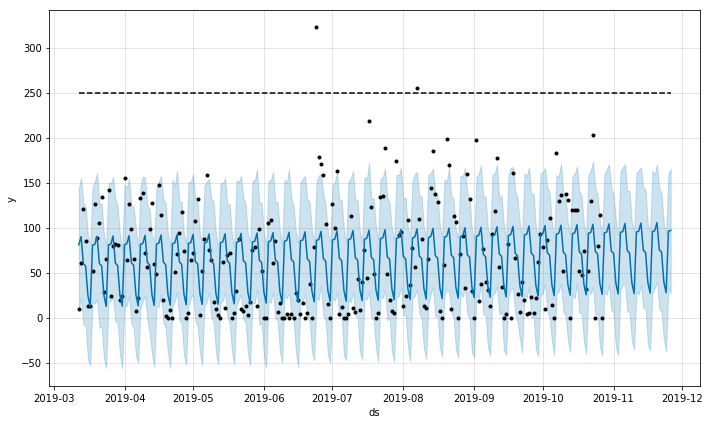

In [188]:
fig1 = m.plot(forecast)

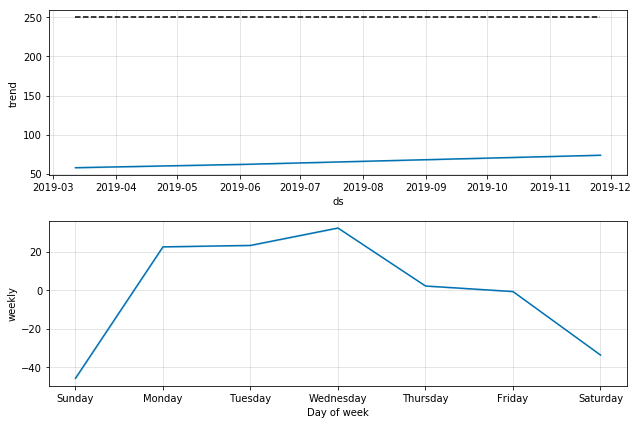

In [189]:
fig2 = m.plot_components(forecast)

In [88]:
results.head()

,ds,y,floor,cap,split,yhat
0,2019-03-12,10,0,200,train,92.401510
1,2019-03-13,61,0,200,train,101.455795
2,2019-03-14,121,0,200,train,71.352601
3,2019-03-15,85,0,200,train,68.481857
4,2019-03-16,13,0,200,train,35.510924


In [22]:
# change column names
rosie_prophet_df = rename_columns_for_prophet(rosie_daily_plays)
carl_propeht_df = rename_columns_for_prophet(carl_daily_plays)
m = Prophet()
m.fit(carl_propeht_df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [23]:
future = m.make_future_dataframe(periods=60)
future.tail()

,ds
315,2020-01-21
316,2020-01-22
317,2020-01-23
318,2020-01-24
319,2020-01-25


In [37]:
future['floor'] = 8.5
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
315,2020-01-21,94.444755,26.064417,162.840107
316,2020-01-22,100.354704,33.700054,166.715447
317,2020-01-23,71.615525,5.977619,138.092471
318,2020-01-24,68.238165,5.957774,135.891521
319,2020-01-25,34.178144,-33.438949,99.806065


In [31]:
forecast.head()

,ds,trend,cap,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-03-12,58.146315,8.5,18.953020,147.213289,58.146315,58.146315,24.883179,24.883179,24.883179,24.883179,24.883179,24.883179,0.0,0.0,0.0,83.029495
1,2019-03-13,58.182582,8.5,21.323858,154.806175,58.182582,58.182582,30.756913,30.756913,30.756913,30.756913,30.756913,30.756913,0.0,0.0,0.0,88.939495
2,2019-03-14,58.218849,8.5,-9.691667,121.297763,58.218849,58.218849,1.981518,1.981518,1.981518,1.981518,1.981518,1.981518,0.0,0.0,0.0,60.200367
3,2019-03-15,58.255116,8.5,-10.517105,118.898643,58.255116,58.255116,-1.432058,-1.432058,-1.432058,-1.432058,-1.432058,-1.432058,0.0,0.0,0.0,56.823058
4,2019-03-16,58.291383,8.5,-40.193378,85.425003,58.291383,58.291383,-35.528296,-35.528296,-35.528296,-35.528296,-35.528296,-35.528296,0.0,0.0,0.0,22.763087


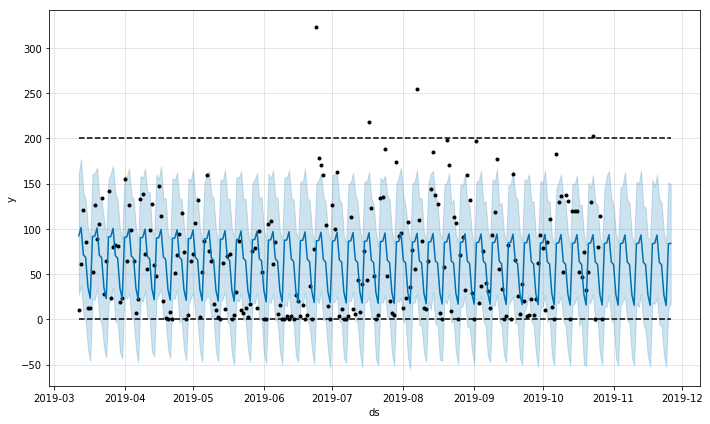

In [89]:
fig1 = m.plot(forecast)

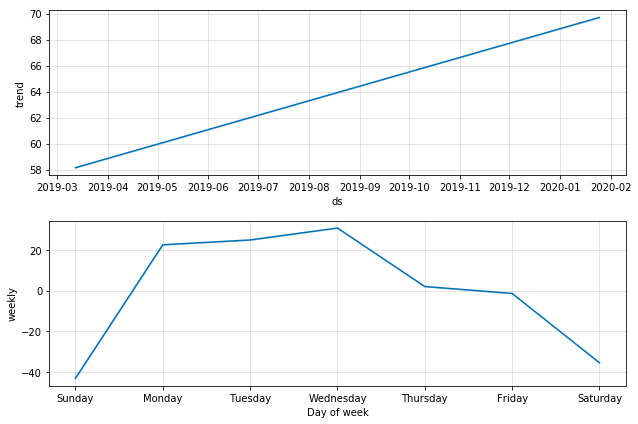

In [26]:
fig2 = m.plot_components(forecast)

In [27]:
rosie_daily_plays.describe()

,song_count
count,260.000000
mean,25.342308
std,26.936400
min,0.000000
25%,2.000000
50%,16.000000
75%,40.000000
max,104.000000


In [208]:
carl_daily_plays.describe()

,song_count
count,260.000000
mean,63.142308
std,58.285138
min,0.000000
25%,10.750000
50%,52.000000
75%,100.500000
max,323.000000


In [192]:
255*4/60

17.0

In [194]:
crazy_carl_day = scrobble_history[(scrobble_history['username']=="COKUNUBI")&
                                  (scrobble_history['play_date']=='2019-06-24')]

In [197]:
crazy_carl_day.sort_values(by = 'play_datetime')

,song,artist,play_time,download_time,username,time_type,play_datetime,play_date
10961,Twofifteen,Black Thought,24Jun7:55am,2019-11-26 11:47:24.106156,COKUNUBI,datetime,2019-06-24 07:55:00,2019-06-24
10960,9th vs. Thought,Black Thought,24Jun7:58am,2019-11-26 11:47:24.106156,COKUNUBI,datetime,2019-06-24 07:58:00,2019-06-24
10959,Dostoyevsky,Black Thought,24Jun8:01am,2019-11-26 11:47:24.106156,COKUNUBI,datetime,2019-06-24 08:01:00,2019-06-24
10958,Making a Murderer,Black Thought,24Jun8:05am,2019-11-26 11:47:24.106156,COKUNUBI,datetime,2019-06-24 08:05:00,2019-06-24
10957,Thank You,Black Thought,24Jun8:10am,2019-11-26 11:47:24.106156,COKUNUBI,datetime,2019-06-24 08:10:00,2019-06-24
...,...,...,...,...,...,...,...,...
10643,Adios,kaizen 92,24Jun10:21pm,2019-11-26 11:47:24.106156,COKUNUBI,datetime,2019-06-24 22:21:00,2019-06-24
10642,Paseo,kaizen 92,24Jun10:22pm,2019-11-26 11:47:24.106156,COKUNUBI,datetime,2019-06-24 22:22:00,2019-06-24
10641,Descanso,kaizen 92,24Jun10:23pm,2019-11-26 11:47:24.106156,COKUNUBI,datetime,2019-06-24 22:23:00,2019-06-24
10640,Jugoso,kaizen 92,24Jun10:24pm,2019-11-26 11:47:24.106156,COKUNUBI,datetime,2019-06-24 22:24:00,2019-06-24


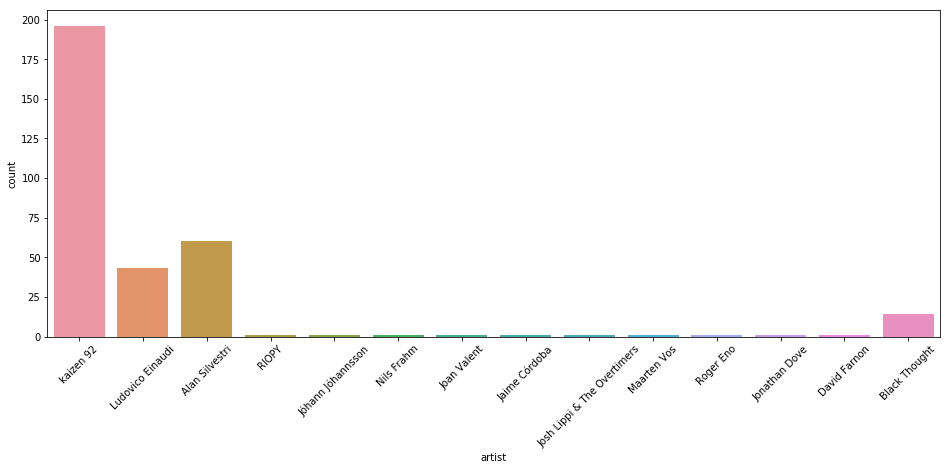

In [202]:
plt.figure(figsize=(16, 6))
plt.xticks(rotation=45)
sns.countplot(data=crazy_carl_day, x="artist")

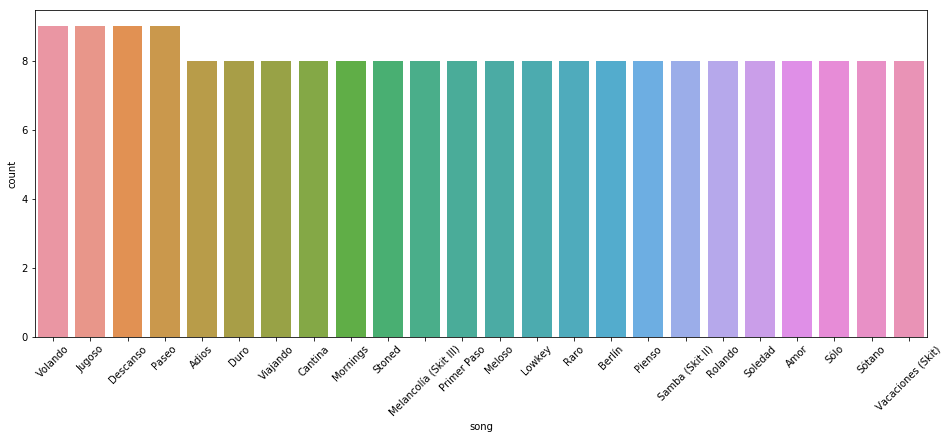

In [204]:
kaizen = crazy_carl_day[crazy_carl_day['artist']=='kaizen 92']
plt.figure(figsize=(16, 6))
plt.xticks(rotation=45)
sns.countplot(data=kaizen, x="song")

In [209]:
kaizen.sort_values(by = 'play_datetime')

,song,artist,play_time,download_time,username,time_type,play_datetime,play_date
10834,Paseo,kaizen 92,24Jun7:28pm,2019-11-26 11:47:24.106156,COKUNUBI,datetime,2019-06-24 19:28:00,2019-06-24
10833,Descanso,kaizen 92,24Jun7:29pm,2019-11-26 11:47:24.106156,COKUNUBI,datetime,2019-06-24 19:29:00,2019-06-24
10831,Volando,kaizen 92,24Jun7:30pm,2019-11-26 11:47:24.106156,COKUNUBI,datetime,2019-06-24 19:30:00,2019-06-24
10832,Jugoso,kaizen 92,24Jun7:30pm,2019-11-26 11:47:24.106156,COKUNUBI,datetime,2019-06-24 19:30:00,2019-06-24
10830,Vacaciones (Skit),kaizen 92,24Jun7:32pm,2019-11-26 11:47:24.106156,COKUNUBI,datetime,2019-06-24 19:32:00,2019-06-24
...,...,...,...,...,...,...,...,...
10643,Adios,kaizen 92,24Jun10:21pm,2019-11-26 11:47:24.106156,COKUNUBI,datetime,2019-06-24 22:21:00,2019-06-24
10642,Paseo,kaizen 92,24Jun10:22pm,2019-11-26 11:47:24.106156,COKUNUBI,datetime,2019-06-24 22:22:00,2019-06-24
10641,Descanso,kaizen 92,24Jun10:23pm,2019-11-26 11:47:24.106156,COKUNUBI,datetime,2019-06-24 22:23:00,2019-06-24
10640,Jugoso,kaizen 92,24Jun10:24pm,2019-11-26 11:47:24.106156,COKUNUBI,datetime,2019-06-24 22:24:00,2019-06-24


In [190]:
carl_daily_plays.sort_values(by='song_count', ascending=False)

,play_date,song_count
104,2019-06-24,323
148,2019-08-07,255
245,2019-11-12,224
127,2019-07-17,218
225,2019-10-23,203
...,...,...
92,2019-06-12,0
90,2019-06-10,0
89,2019-06-09,0
235,2019-11-02,0


In [196]:
user_df_dict['COKUNUBI']

,play_date,song_count
0,2019-03-12,10
1,2019-03-13,61
2,2019-03-14,121
3,2019-03-15,85
4,2019-03-16,13
5,2019-03-17,13
6,2019-03-18,52
7,2019-03-19,126
8,2019-03-20,89
9,2019-03-21,105


In [165]:
user_df_dict

{'COKUNUBI':      play_date  song_count
 0   2019-03-12          10
 1   2019-03-13          61
 2   2019-03-14         121
 3   2019-03-15          85
 4   2019-03-16          13
 5   2019-03-17          13
 6   2019-03-18          52
 7   2019-03-19         126
 8   2019-03-20          89
 9   2019-03-21         105
 10  2019-03-22         134
 11  2019-03-23          28
 12  2019-03-24          65
 13  2019-03-25         142
 14  2019-03-26          24
 15  2019-03-27          80
 16  2019-03-28          82
 17  2019-03-29          81
 18  2019-03-30          19
 19  2019-03-31          24
 20  2019-04-01         155
 21  2019-04-02          64
 22  2019-04-03         126
 23  2019-04-04          99
 24  2019-04-05          65
 25  2019-04-06           7
 26  2019-04-07          22
 27  2019-04-08         133
 28  2019-04-09         139
 29  2019-04-10          72
 ..         ...         ...
 201 2019-10-23         203
 202 2019-10-25          80
 203 2019-10-26         114
 204 201

In [151]:
carl_df, rosie_df = create_timeseries_for_each_user(daily_plays_df,['COKUNUBI','rosiedempsey93'])

In [150]:
carl_df.head()

AttributeError: 'str' object has no attribute 'head'

In [181]:
daily_plays_df.head()

,username,play_date,song_count
0,COKUNUBI,2019-03-12,10
1,COKUNUBI,2019-03-13,61
2,COKUNUBI,2019-03-14,121
3,COKUNUBI,2019-03-15,85
4,COKUNUBI,2019-03-16,13


In [184]:
# using the resample method
# daily_plays_df.set_index(daily_plays_df['play_date'], inplace=True)
daily_plays_df = daily_plays_df.resample('D').sum().fillna(0)

In [185]:
daily_plays_df.head()

,song_count
play_date,
2019-03-12,44
2019-03-13,95
2019-03-14,124
2019-03-15,95
2019-03-16,15


In [111]:
idx = pd.period_range(min(daily_plays_df['play_date']), max(daily_plays_df['play_date']))
daily_plays_df = daily_plays_df.set_index('play_date')

In [112]:
daily_plays_df.reindex(idx, fill_value=0)

ValueError: cannot reindex from a duplicate axis

In [102]:
idx

PeriodIndex(['2019-03-12', '2019-03-13', '2019-03-14', '2019-03-15',
             '2019-03-16', '2019-03-17', '2019-03-18', '2019-03-19',
             '2019-03-20', '2019-03-21',
             ...
             '2019-11-17', '2019-11-18', '2019-11-19', '2019-11-20',
             '2019-11-21', '2019-11-22', '2019-11-23', '2019-11-24',
             '2019-11-25', '2019-11-26'],
            dtype='period[D]', length=260, freq='D')

In [109]:
daily_plays_df.tail()

,username,play_date,song_count
2019-11-22,0,0,0
2019-11-23,0,0,0
2019-11-24,0,0,0
2019-11-25,0,0,0
2019-11-26,0,0,0


## Check data quality

In [25]:
scrobble_history.head()

,song,artist,play_time,download_time,username,time_type,play_datetime,play_date
0,Touching the Skies,Bo Thelin,9hoursago,2019-11-26 11:47:24.106156,COKUNUBI,hours_ago,2019-11-26 02:47:24.106156,2019-11-26
1,The How of it Sped,Bing & Ruth,10hoursago,2019-11-26 11:47:24.106156,COKUNUBI,hours_ago,2019-11-26 01:47:24.106156,2019-11-26
2,Meadow Mornings,Samuel Lindon,10hoursago,2019-11-26 11:47:24.106156,COKUNUBI,hours_ago,2019-11-26 01:47:24.106156,2019-11-26
3,Petite Partie,Firestore,10hoursago,2019-11-26 11:47:24.106156,COKUNUBI,hours_ago,2019-11-26 01:47:24.106156,2019-11-26
4,Sugarcane,Ana Olgica,10hoursago,2019-11-26 11:47:24.106156,COKUNUBI,hours_ago,2019-11-26 01:47:24.106156,2019-11-26


In [29]:
daily_plays_df.head()

,username,play_date,song_count
0,COKUNUBI,2019-03-12,10
1,COKUNUBI,2019-03-13,61
2,COKUNUBI,2019-03-14,121
3,COKUNUBI,2019-03-15,85
4,COKUNUBI,2019-03-16,13


In [58]:
daily_plays_df.groupby('username').describe()

song_count                                                     
                    count       mean        std  min   25%   50%    75%    max
username                                                                      
COKUNUBI            231.0  71.069264  57.093626  2.0  19.5  64.0  108.5  323.0
rosiedempsey93      202.0  32.618812  26.389509  1.0  11.0  25.0   50.0  104.0

In [79]:
date_check  = daily_plays_df.groupby('username')[['play_date']].agg({'min','max'})
concat_multi_index_cols(date_check)
date_check['date_range'] = date_check['play_date_max']-date_check['play_date_min']
date_check
# count is different even though we have listened the same number of days
# need to add blank dates and fill song_count with 0!

,play_date_min,play_date_max,date_range
username,,,
COKUNUBI,2019-03-12,2019-11-26,259 days
rosiedempsey93,2019-03-12,2019-11-26,259 days


In [64]:
date_check.columns

MultiIndex(levels=[['play_date'], ['min', 'max']],
           codes=[[0, 0], [0, 1]])

In [31]:
rosie_daily_plays.head()

,play_date,song_count
231,2019-03-12,34
232,2019-03-13,34
233,2019-03-14,3
234,2019-03-15,10
235,2019-03-16,2


In [32]:
carl_daily_plays.head()

,play_date,song_count
0,2019-03-12,10
1,2019-03-13,61
2,2019-03-14,121
3,2019-03-15,85
4,2019-03-16,13


## Look at data

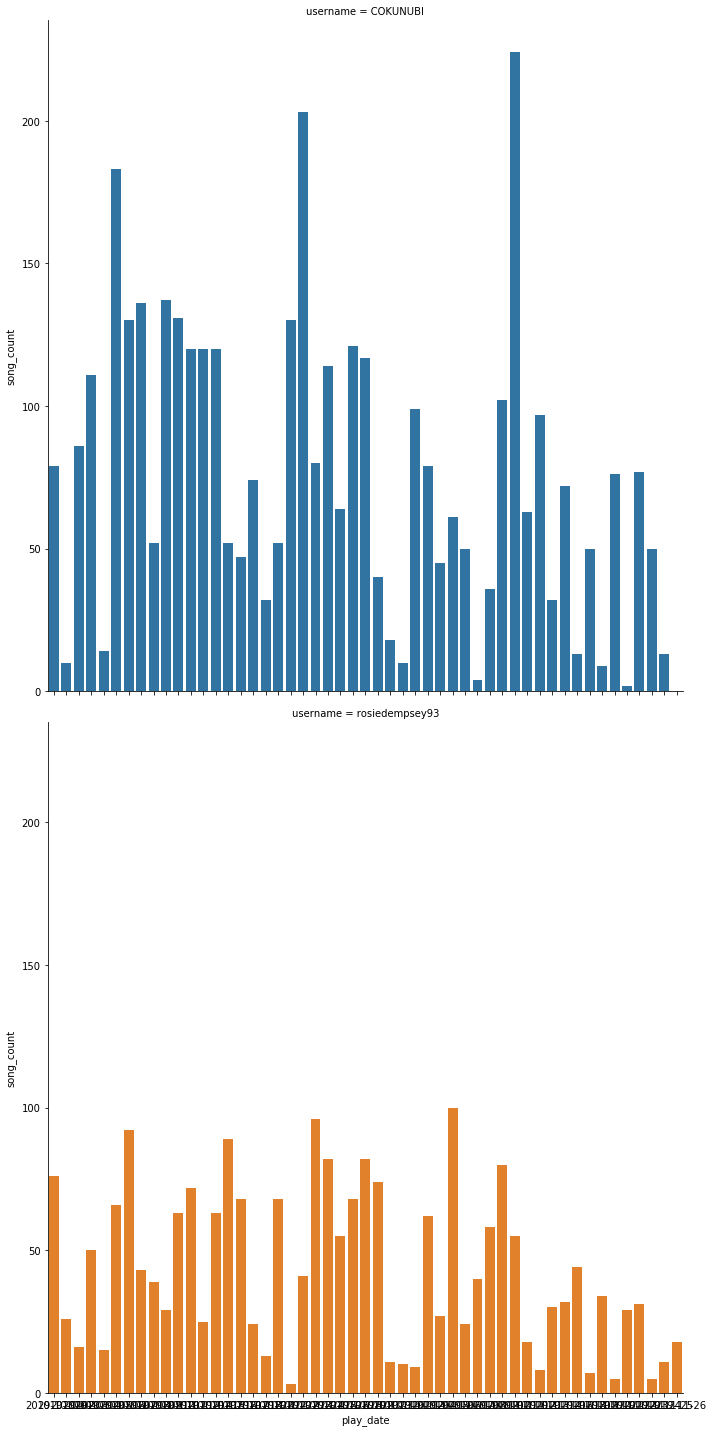

In [44]:
plot_df = daily_plays_df[daily_plays_df['play_date']>=pd.to_datetime('2019-10-01').date()]
g = sns.FacetGrid(plot_df, col="username",  hue="username", size=10, col_wrap=1)
g = g.map(sns.barplot, "play_date", "song_count")

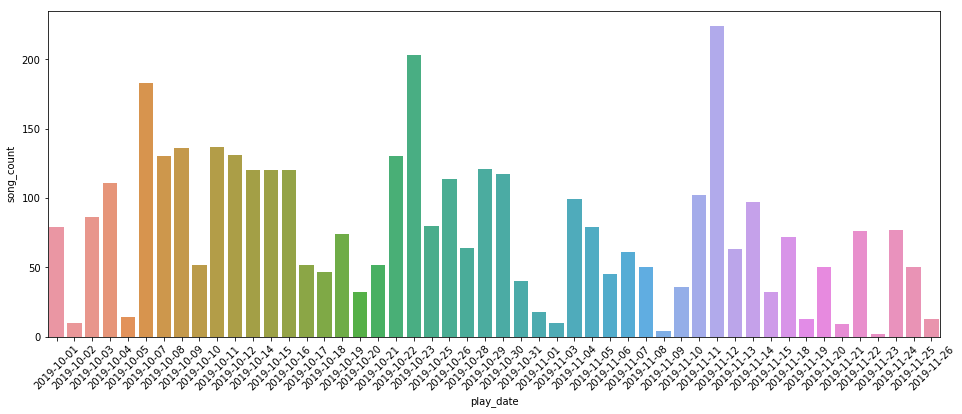

In [55]:
plot_df = carl_daily_plays[carl_daily_plays['play_date']>=pd.to_datetime('2019-10-01').date()]
plt.figure(figsize=(16, 6))
plt.xticks(rotation=45)
g = sns.barplot(data=plot_df, x="play_date", y="song_count")

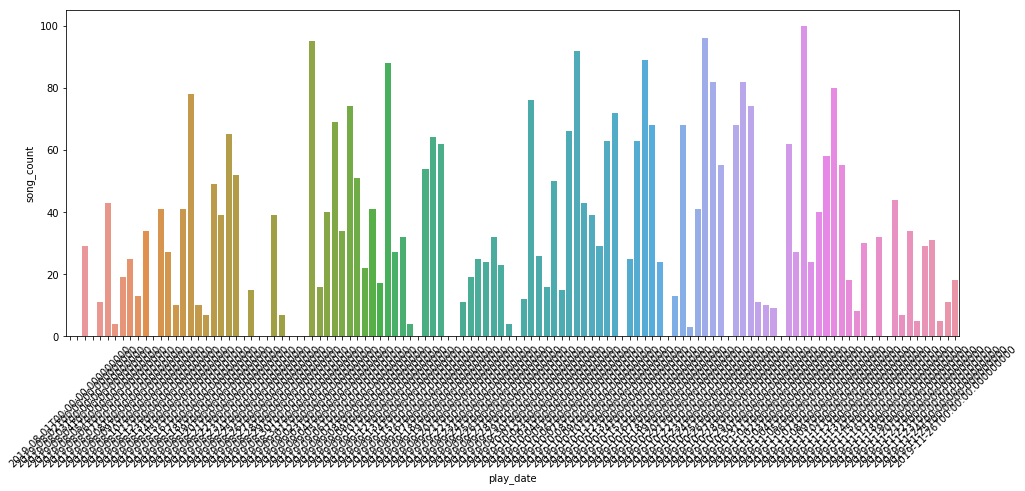

In [210]:
plot_df = rosie_daily_plays[rosie_daily_plays['play_date']>=pd.to_datetime('2019-08-01').date()]
plt.figure(figsize=(16, 6))
plt.xticks(rotation=45)
g = sns.barplot(data=plot_df, x="play_date", y="song_count")